In [2]:
import numpy as np
import os
import cv2
import os
from keras import layers
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.layers import Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras import layers, models
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg19 import VGG19

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data='/kaggle/input/chest-xray-pneumonia'

In [4]:
train = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test= '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

In [5]:
if os.path.exists(train):
   print(f"Train data is located at {train}")
else:
   print(f"Train data is not located at {train}")

if os.path.exists(val):
   print(f"Train data is located at {val}")
else:
   print(f"Train data is not located at {val}")

if os.path.exists(test):
   print(f"Test data is located at {test}")
else:
   print(f"Test data is not located at {test}")

Train data is located at /kaggle/input/chest-xray-pneumonia/chest_xray/train
Train data is located at /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test data is located at /kaggle/input/chest-xray-pneumonia/chest_xray/test


In [6]:
batch_size = 32
img_width=224
img_height=224
img_size=128
epochs=50
NUM_CLASSES=2

In [7]:
data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'binary',
    seed = 42,
    subset='training')

validation_generator = data_generator.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'binary',
    seed = 42,
    subset='validation')

Found 4173 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [8]:
import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 129/129 [02:36<00:00,  1.21s/it]

(4160, 224, 224, 3) (4160,)


In [9]:
X_test, y_test = next(validation_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 129/129 [03:54<00:00,  1.82s/it]

(8269, 224, 224, 3) (8269,)


In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(1):  # Apply augmentation twice
            for batch in datagen.flow(img, batch_size=1):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

In [11]:
from sklearn.preprocessing import LabelEncoder


# Apply augmentation twice to X_train, X_test, and X_val
X_train_augmented = augment_dataset(X_train)
X_test_augmented = augment_dataset(X_test)
#X_val_augmented = augment_dataset(X_val)
label_encoder = LabelEncoder()
y_train_augmented = np.repeat(y_train, 1, axis=0)# Adjust based on augmentation factor
y_train_augmented = y_train_augmented.reshape(-1, 1)
y_test_augmented = np.repeat(y_test, 1, axis=0)  # Adjust based on augmentation factor
y_test_augmented = y_test_augmented.reshape(-1, 1)

In [12]:
img_rows, img_cols = 224, 224
inception_v3= InceptionV3 (weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))


for layer in inception_v3.layers:
    layer.trainable = False
# Let's print our layers
for (i,layer) in enumerate(inception_v3.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

87910968/87910968 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1,activation='sigmoid')(top_model)
    
    return top_model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D


from keras.models import Model


num_classes = 2

FC_Head = lw(inception_v3, num_classes)


model = Model(inputs = inception_v3.input, outputs = FC_Head)

In [15]:
from keras.models import Model
import tensorflow as tf
from keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.F1Score(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),]

In [16]:
def custom_binary_crossentropy(y_true, y_pred):
    # Adjust the loss calculation based on your requirements
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), loss = 'binary_crossentropy',metrics = metrics)

In [17]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=3,
         restore_best_weights=True,
    )
]
history = model.fit(X_train_augmented, y_train_augmented, epochs=100,batch_size=32,validation_split=0.2,callbacks=callbacks)

Epoch 1/100
207/207 [==============================] - 31s 90ms/step - loss: 0.3780 - accuracy: 0.8348 - auc: 0.8801 - recall: 0.9112 - precision: 0.8724 - f1_score: 0.8533 - specificity_at_sensitivity: 0.9510 - sensitivity_at_specificity: 0.9470 - false_negatives: 437.0000 - false_positives: 656.0000 - true_negatives: 1037.0000 - true_positives: 4485.0000 - val_loss: 0.2744 - val_accuracy: 0.8809 - val_auc: 0.9409 - val_recall: 0.9401 - val_precision: 0.9023 - val_f1_score: 0.8482 - val_specificity_at_sensitivity: 0.9908 - val_sensitivity_at_specificity: 0.9811 - val_false_negatives: 73.0000 - val_false_positives: 124.0000 - val_true_negatives: 312.0000 - val_true_positives: 1145.0000
Epoch 2/100
207/207 [==============================] - 12s 59ms/step - loss: 0.2600 - accuracy: 0.8869 - auc: 0.9440 - recall: 0.9330 - precision: 0.9166 - f1_score: 0.8533 - specificity_at_sensitivity: 0.9870 - sensitivity_at_specificity: 0.9811 - false_negatives: 330.0000 - false_positives: 418.0000 - 

In [18]:
model.evaluate(X_train_augmented,y_train_augmented)

259/259 [==============================] - 13s 50ms/step - loss: 0.1610 - accuracy: 0.9360 - auc: 0.9800 - recall: 0.9689 - precision: 0.9462 - f1_score: 0.8522 - specificity_at_sensitivity: 0.9967 - sensitivity_at_specificity: 0.9969 - false_negatives: 191.0000 - false_positives: 338.0000 - true_negatives: 1791.0000 - true_positives: 5949.0000


[0.1610138863325119,
 0.9360260963439941,
 0.9799687266349792,
 0.968892514705658,
 0.9462382793426514,
 array([0.85224515], dtype=float32),
 0.9967120885848999,
 0.9969055652618408,
 191.0,
 338.0,
 1791.0,
 5949.0]

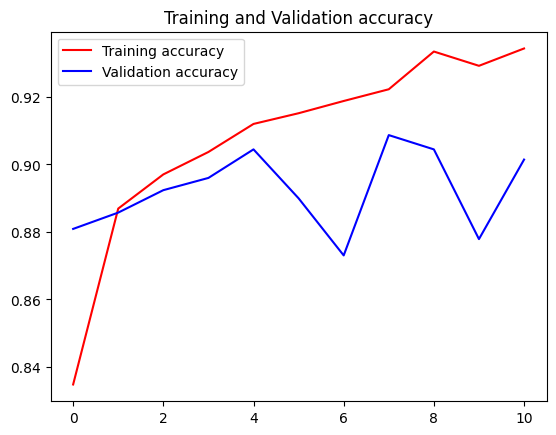

<Figure size 640x480 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

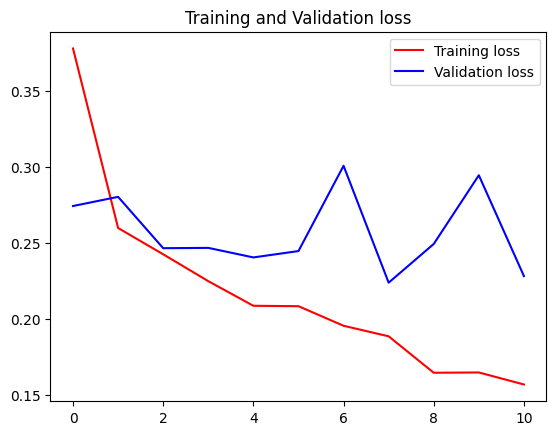

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 1s 1s/step


Text(0.5, 36.72222222222221, 'Predicted')

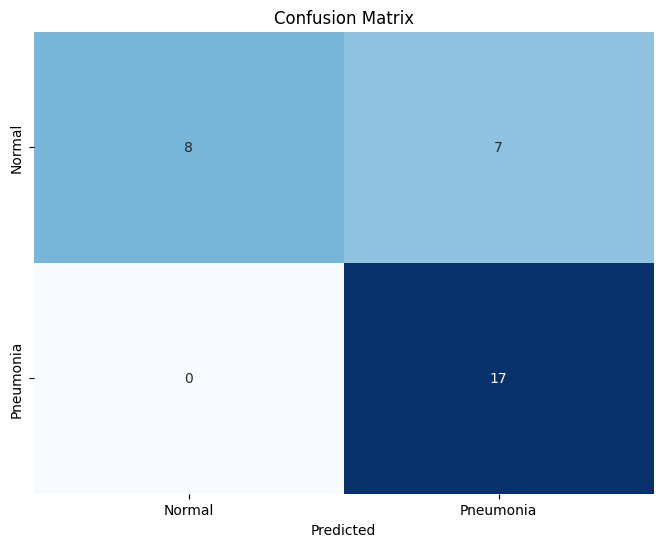

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already trained your model and obtained predictions
# For example:
predictions = model.predict(X_test_augmented)

# Assuming predictions are probabilities, you can convert them to binary classes
y_pred = (predictions > 0.5).astype(int)

# Assuming y_test is your true labels
y_true = y_test_augmented  # Change this accordingly

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
